In [ ]:
#@title Download model

!git init .
!git remote add -f origin "https://github.com/Sankek/ImageInpainting"
!git pull origin master

# 130000
# state_url = 'https://drive.google.com/uc?id=1-INTkzwusTbuDgWxgSZQgzwQSxP_wNoP'
# 210000
# state_url = 'https://drive.google.com/uc?id=1i1vKX8OfLIdvGtQ0iEr7P-PzzekO4mOz'
# branch2_190000
# state_url = 'https://drive.google.com/uc?id=1HyeZPMaaK2iYkIoUHiVoj83ytPrSuLFr'

# 350000
# state_url = 'https://drive.google.com/uc?id=1kBki6y60qV1Dra15s5UUEczuNtOaIGnw'

# finetune 360000
# state_url = 'https://drive.google.com/uc?id=1DK-f20JpHmYTsL-BQVKGBY5EtMmaiIEb'

# finetune 440000
# state_url = 'https://drive.google.com/uc?id=1E-jaOInZh3SAY9V8MuK8K6_rGU3eYzxC'

# finetune 490000
# state_url = 'https://drive.google.com/uc?id=1GU4G734V9VDsAPAJlKPm5XU0GoEM93pa'

# finetune 580000
# state_url = 'https://drive.google.com/uc?id=1O3seOA-30Pks8pk7MUGtONFtql1BSTtY'

# finetune_lr_1e-4 590000
# state_url = 'https://drive.google.com/uc?id=1N-GdDGBMh9EsaCaIvAtn5p1PTOPJsz7U'

# finetune_lr_1e-4 760000
state_url = 'https://drive.google.com/uc?id=1q7B9vd1flFhz4Nb_Z2oxjB-Yw6YdsryD'

# ---------------
# norm_losses 350000
# state_url = 'https://drive.google.com/uc?id=1iKiwSHCWPDkimBaNa3ZrE8hnlMrwuPHz'

# norm_losses_off_bn 360000
# state_url = 'https://drive.google.com/uc?id=1ni7DiVG25cWcCVbLIE4W5wM4RPMAwfED'

# norm_losses_off_bn 440000
# state_url = 'https://drive.google.com/uc?id=1y6h_guvmZw0QSrNMhpvdB2QCb80KlSPx'

import gdown
gdown.download(state_url, 'state.pth', quiet=False)

In [2]:
#@title Upload an image (The width and height of the image must be divisible by 16.)

from google.colab import files
from PIL import Image
import base64
from io import BytesIO

uploaded = files.upload()
original_image_pil = Image.open(list(uploaded)[0])
original_image_pil = original_image_pil.convert('RGB')
width, height = original_image_pil.width, original_image_pil.height
buffered = BytesIO()
original_image_pil.save(buffered, format="png")
img_base64 = base64.b64encode(buffered.getvalue())
img_base64 = str(img_base64)[2:-1]

Saving 79.jpg to 79.jpg



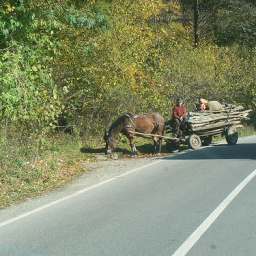

In [3]:
#@title Draw mask
#modifed from: https://gist.github.com/korakot/8409b3feec20f159d8a50b0a811d3bca

color = "pink" #@param ["black", "white", "pink"]

rgb_to_hex = {
    'black': '#000000',
    'white': '#ffffff',
    'pink': '#ff00ff',
}


from IPython.display import HTML, display
from google.colab.output import eval_js
from base64 import b64decode

canvas_html = """
<div id="canvasesdiv" style="width:%(width)dpx; height:%(height)dpx">
<canvas id="canvas1"
style="z-index: 1;
position:absolute;
left:0px;
top:0px;
" width=%(width)d height=%(height)d>
</canvas>
<canvas id="canvas2"
style="z-index: 2;
position:absolute;
left:0px;
top:0px;
" width=%(width)d height=%(height)d>
</canvas>
</div>

<div class="slidecontainer">
  <input type="range" id="rangeInput" name="rangeInput" min="0.1" max="25" step="0.1" value="5"
       oninput="amount.value=rangeInput.value">          
  <output id="rangeName" name="rangeName">Line Width:</output>
  <output id="amount" name="amount" for="rangeInput">5</output>
</div>

<button>Finish</button>

<script>
var canvasTop = document.getElementById('canvas2')
var canvasBottom = document.getElementById('canvas1')
var range = document.getElementById('rangeInput')
var ctxTop = canvasTop.getContext('2d')
ctxTop.strokeStyle = "%(color)s"
var ctxBottom = canvasBottom.getContext('2d')
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

var img = new Image;
img.onload = function(){
  ctxBottom.drawImage(img, 0, 0);
}
img.src = "data:image/png;base64,%(img)s";

canvasTop.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvasTop.onmousedown = ()=>{
  ctxTop.lineWidth = range.value
  ctxTop.beginPath()
  ctxTop.moveTo(mouse.x, mouse.y)
  canvasTop.addEventListener('mousemove', onPaint)
}
canvasTop.onmouseup = ()=>{
  canvasTop.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctxTop.lineTo(mouse.x, mouse.y)
  ctxTop.stroke()
}
var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvasTop.toDataURL('image/png'));
  }
})
</script>
"""

def draw(img, width, height, color='#FFFFFF', filename='drawing.png'):
  display(HTML(canvas_html % dict(width=width, height=height, img=img, color=color)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  return binary

binary = draw(img_base64, width, height, color=rgb_to_hex[color])

In [4]:
#@title Inpaint the image

import numpy as np
import torch
import torchvision.transforms as tt

def tensor2image(inp, dataset_mean, dataset_std):
    """Преобразует PyTorch тензоры для использования в np.imshow"""
    out = inp.cpu().detach().numpy().transpose((1, 2, 0))
    mean = np.array(dataset_mean)
    std = np.array(dataset_std)
    out = std * out + mean

    return np.clip(out, 0, 1)

mask = Image.open(BytesIO(binary))
mask = np.array(mask)[:, :, :3].max(axis=2)
hole = mask != 0
valid = ~hole
mask[valid] = 255
mask[hole] = 0

mask = torch.FloatTensor(mask/255)
mask = mask.view(1, 1, height, width).expand(-1, 3, -1, -1)

dataset_mean = [0.485, 0.456, 0.406] 
dataset_std = [0.229, 0.224, 0.225]
transform = tt.Compose([
            tt.ToTensor(),
            tt.Normalize(dataset_mean, dataset_std)
            ])

original_image = transform(original_image_pil).unsqueeze(0)

state = torch.load('state.pth', map_location='cpu')
model = state['model']
model.load_state_dict(state['model_state'])
model.eval()

output, _ = model(mask*original_image, mask)
output = tensor2image(output[0], dataset_mean, dataset_std)
mask = tensor2image(mask[0], [0]*3, [1]*3)
original_image = tensor2image(original_image[0], dataset_mean, dataset_std)
masked_image = original_image*mask+1*(1-mask)
completed_image = original_image*mask+output*(1-mask)

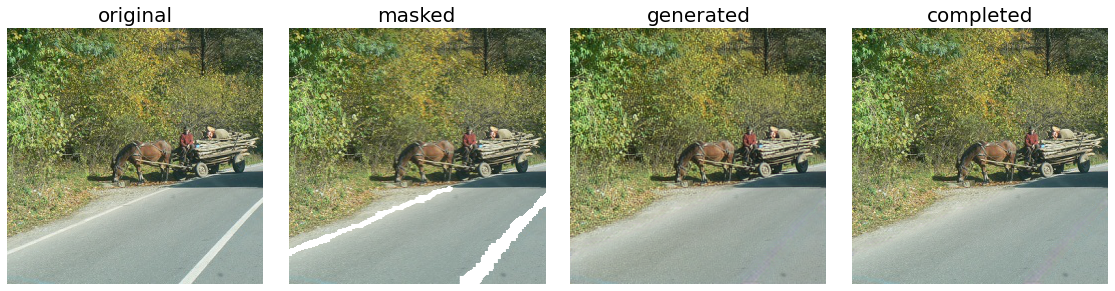

In [5]:
#@title Show the result

import matplotlib.pyplot as plt
import matplotlib as mpl

dpi = mpl.rcParams['figure.dpi']
figsize = np.array(output.shape[:2])/dpi
figsize[0] *= 4
fig = plt.figure(figsize=figsize)
ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes([1/4+0.1/4, 0, 1, 1])
ax3 = fig.add_axes([2/4+0.2/4, 0, 1, 1])
ax4 = fig.add_axes([3/4+0.3/4, 0, 1, 1])
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
ax1.imshow(original_image)
ax2.imshow(masked_image)
ax3.imshow(output)
ax4.imshow(completed_image)
ax1.set_title('original', fontsize=20)
ax2.set_title('masked', fontsize=20)
ax3.set_title('generated', fontsize=20)
ax4.set_title('completed', fontsize=20)
plt.show()